<a href="https://colab.research.google.com/github/microprediction/winning/blob/main/Kentucky_Derby_2021_Blog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install winning
from winning.lattice import skew_normal_density, densities_from_offsets, pdf_to_cdf, sample_from_cdf
from winning.lattice_calibration import dividend_implied_ability, prices_from_dividends
import numpy as np
from collections import Counter
import heapq
from pprint import pprint
import pandas as pd

# Kentucky Derby Exactas
This notebook illustrates:


1.   Fast calibration of a performance model
2.   Monte Carlo of Exacta probabilities

The first thing we'll need are the current odds. I couldn't find a good API so...


In [38]:
derby = {'Max Player':19,
         'Enforceable':22,
         'Storm The Court':27,
         'Major Fed':43,
         'Money Moves':13,
         'South Bend':36,
         'Mr Big News':46,
         'Necker Island':49,
         'Sole Volante':32,
         'Attachment Rate':47,
         'Winning Impression':50,
         'NY Traffic':12,
         'Honor A. P.':7,
         'Tiz The Law':0.6,
         'Authentic':8}

sorted_derby = {k: v for k, v in sorted(derby.items(), key=lambda item: item[1])}
DERBY = sorted_derby.values()
names = sorted_derby.keys()


### Performance model
I'll assume each horse has a skew-normal performance. However you can use any distribution in what follows. 


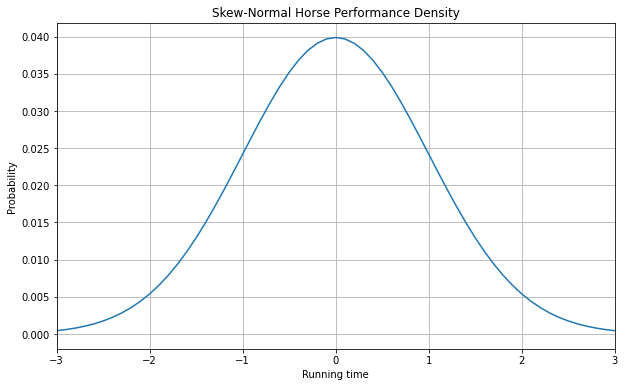

In [40]:
from winning.lattice_conventions import STD_UNIT, STD_SCALE, STD_L, STD_A
from winning.lattice_plot import densitiesPlot
from winning.lattice import symmetric_lattice
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
density=skew_normal_density(L=STD_L, unit=STD_UNIT, scale=STD_SCALE, a=STD_A)
def densityPlot( density, L, unit, legend = None ):
    import matplotlib.pyplot as plt
    pts = symmetric_lattice( L=L, unit=unit )
    ax = plt.plot( pts, density )
    plt.xlim([-3,3])
    plt.title('Skew-Normal Horse Performance Density')
    plt.ylabel('Probability')
    plt.xlabel('Running time')
    plt.grid()
    plt.show()

densityPlot(density,L=STD_L,unit=STD_UNIT)



### Calibration
What if every horse's performance were a translation of this standard horse performance? In theory we can adjust the location parameter so as to align with the published winning odds. 

First, however, we need to do something remotely sensible to account for the long-shot effect and then normalize the market win probabiltiies. 

In what follows, the "dividends" are inverse probabilities (a convention from Australia and elsewhere - whoever decided to express U.S. odds in terms of $2 bets??)



In [41]:
def _normalize(ps):
    s = sum(ps)
    if s>1e-6:
        return [ p/s for p in ps ]
    else:
        return [ 0.0 for p in ps ]

dividends = [ (o+1.0)**(1.17) for o in DERBY ] # <-- Unwind longshot, approximately
sum_of_prob = sum([1/d for d in dividends])
sum_of_prob, dividends
probabilities = _normalize( [ 1/dividend if dividend>0 else 0.0 for dividend in dividends ])
  

You'll notice that the favorite is now priced at 0.73 : 1 as compared with  4:6 

Now we turn to calibration of the location parameters. This is the reason the winning package exists, and the paper. 

*Inferring Relative Ability from Winning Probability in Multientrant Contest*s
P Cotton
SIAM Journal on Financial Mathematics 12 (1), 295-317 

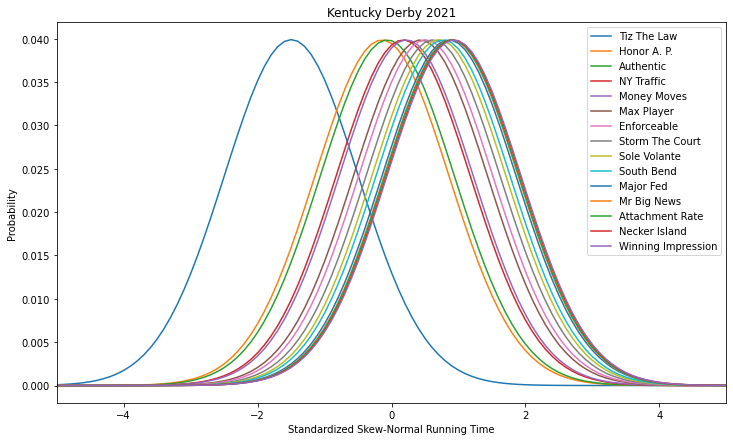

In [50]:
offsets = dividend_implied_ability(dividends=dividends, density=density)
densities = densities_from_offsets(density=density,offsets=offsets)
plt.rcParams["figure.figsize"] = (12,7)
def densitiesPlot( densities, unit, legend = None ):
    import matplotlib.pyplot as plt
    L = int(len( densities[0]-1 )/2)
    pts = symmetric_lattice( L=L, unit=unit )
    for density in densities:
        plt.plot( pts, density )
    if legend is not None:
        plt.legend( legend )
    plt.xlim([-5,5]) 
    plt.title('Kentucky Derby 2021')
    plt.xlabel('Standardized Skew-Normal Running Time') 
    plt.ylabel('Probability')
   
densitiesPlot(densities=densities,unit=STD_UNIT, legend=list(names))

Beautiful! 

### Monte Carlo pricing
Needless to say if we assume running times are independent this is a coherent model for performances of every horse and thus it prices every possible horse-racing wager. 

We'll see how the show probabilities compare with an oft-used bookmaker heuristic. I'm going to be lazy in the rest of this notebook and use Monte Carlo to price everything - though that can be improved. 

In [ ]:
# A Monte Carlo model

def placegetter(scores, position):
    return heapq.nsmallest(position+1, range(len(scores)), key=scores.__getitem__)[position]

def sample_from_cdf_with_noise(cdf, nSamples):
    # Break ties
    samples = sample_from_cdf(cdf=cdf,nSamples=nSamples)
    noise = 0.00001*np.random.randn(nSamples)
    return [ s+x for s,x in zip(samples,noise) ]

def sample_exotics( dividends, density, nSamples = 5000 ):
    """ Return counts of ordered results """

    offsets = dividend_implied_ability(dividends=dividends, density=density)
    densities = densities_from_offsets(density=density,offsets=offsets)
    cdfs = [pdf_to_cdf(density) for density in densities]
    cols = [sample_from_cdf_with_noise(cdf, nSamples) for cdf in cdfs]

    rows = list( map( list, zip( *cols )))
    winner   = [ placegetter(row,0) for row in rows ]
    second   = [ placegetter(row,1) for row in rows ]
    third    = [ placegetter(row,2) for row in rows ]
    return exotic_count(winner=winner, second=second, third=third)


def exotic_count(winner, second, third):
    win = Counter(winner)
    place = Counter(second)
    place.update(win)
    show = Counter(third)
    show.update(place)
    exacta = Counter(zip(winner, second))
    trifecta = Counter(zip(winner, second, third))
    return {"win":win, "exacta":exacta, "trifecta":trifecta, "place":place, "show":show}


For avoidance of doubt I'm using the following terminology:


*   Show - Finish in top three
*   Exacta - Pick two horses in order

Bookmakers sometimes use the rule of 1/4 to estimate show probabilities. However they are smart enough to know not to do this if the favourite is odds on! We can use the running time model to see why this could go badly wrong. 

Another benchmark is provided by Luce's Axiom of Choice, which in horseracing circles goes by the name "Harville". This states that when you remove one horse from the race you can simply re-normalize winning probabilities. It sounds reasonable, but it is not so great as it turns out. 




In [48]:
def show_ratios( dividends, density, nSamples=25000, names=None ):
    """
       Comparision to the rule of 1/4
    """
    probabilities = prices_from_dividends(dividends)
    n = len(probabilities)
    monte_carlo = sample_exotics( dividends=dividends, density=density, nSamples=nSamples )
    win  = monte_carlo['win']
    show = monte_carlo["show"]

    nTotal = nSamples
    while True:
        monte_carlo_ = sample_exotics(dividends=dividends, density=density, nSamples=nSamples)
        win_  = monte_carlo_['win']
        show_ = monte_carlo_["show"]
        win.update(win_)
        show.update(show_)
        nTotal += nSamples
        rows = list()
        for k in range(n):
            p = probabilities[k]
            b = 1/p-1              # Bookmaker quoted odds
            b_show  = b/4          # Bookmaker quoted show odds
            p_show  = 1/(b_show+1) # Bookmaker show probability using rule of 1/4
            b_ratio = p_show/p     # Ratio of show probability to win probability
            p_show_model = show[k]/nTotal
            increase = round(100*(p_show_model/p_show-1),1)
            row_data = [ round(x,3) for x in (b,b_show,p_show,p_show_model,increase)]
            rows.append(row_data)

        df = pd.DataFrame.from_records(data=rows,columns=['Win','Show','Bookmaker','Model','Percentage Diff'])
        df.to_csv('rule_of_a_quarter.csv')
       
        if names is not None:
          df['name'] = names
        pprint(df)
        
    return {"show":df}


def exacta_ratios( dividends, density, nSamples=5000 ):
    """
         By Monte Carlo, estimate difference in conditional second place probabilities versus axiom of choice
    """

    probabilities = prices_from_dividends(dividends)
    n = len(probabilities)
    monte_carlo = sample_exotics( dividends=dividends, density=density, nSamples=nSamples )
    win = monte_carlo['win']
    exacta = monte_carlo["exacta"]
    trifecta = monte_carlo["trifecta"]

    nTotal = nSamples
    while True:
        monte_carlo_ = sample_exotics(dividends=dividends, density=density, nSamples=nSamples)
        win_ = monte_carlo_['win']
        exacta_ = monte_carlo_["exacta"]
        trifecta_ = monte_carlo_["trifecta"]
        win.update(win_)
        exacta.update(exacta_)
        trifecta.update(trifecta_)
        nTotal += nSamples
        exacta_ratios = [[0.] * n for _ in range(n)]
        for ex in exacta:
            winner = ex[0]
            second = ex[1]
            p1 = probabilities[winner]
            p2 = probabilities[second]
            conditional_prob = (exacta[ex]/win[winner])
            harville_conditional_prob = p2/(1-p1)
            exacta_ratios[winner][second] = round(conditional_prob/harville_conditional_prob-1,3)
        pprint(exacta_ratios)
        np.savetxt("derby.csv", np.array(exacta_ratios), delimiter=' & ', fmt='%2.2e', newline=' \\\\\n')
    return {"exacta":exacta_ratios}


####################################
#   Harville stuff as a benchmark  #
####################################

def harville_exacta(p1,p2):
    return p1*p2/(1-p1)

def harville_trifecta(p1,p2,p3):
    return p1*p2*p3/((1-p1)*(1-p2))

def harville_probabilities( dividends ):
    """
        Apply axiom of choice
    """

    probabilities = _normalize( [ 1/dividend if dividend>0 else 0.0 for dividend in dividends ])
    n = len(probabilities)
    exacta   = [ [0.]*n for _ in range(n) ]
    quinella = [ [0.]*n for _ in range(n) ]
    trifecta = [ [ [0.]*n for _ in range(n) ] for _ in range(n) ]

    win      = probabilities
    second   = [ 0. ]*n
    third    = [ 0. ]*n

    for k1,p1 in enumerate(probabilities):
        for k2,p2 in enumerate(probabilities):
            if k1 != k2:
                exacta[k1][k2]=harville_exacta(p1=p1,p2=p2)
                second[k2] += exacta[k1][k2]
                if k2>k2:
                    quinella[k1][k2] = harville_exacta(p1=p1,p2=p2)+harville_exacta(p1=p2,p2=p1)
            for k3,p3 in enumerate(probabilities):
                trifecta[k1][k2][k3] = harville_trifecta(p1=p1,p2=p2,p3=p3)
                third[k3] += trifecta[k1][k2][k3]

    show  = [ f+s+t for f,s,t in zip(win,second,third)]
    place = [ f+s  for f, s in zip(win, second)]

    return exacta, quinella, trifecta, win, place, show





# A test of the rule of 1/4
This fails miserably for the Derby due to the presence of such a strong favourite. Rather than fix the density as above, I'm going to allow you to modify it (change the a parameter as you see fit which controls skew). 

In [49]:
bookmaker_ratios(nSamples=1000, dividends=dividends, density=skew_normal_density(L=STD_L, unit=STD_UNIT, scale=STD_SCALE, a=1.5), names=names)


       Win    Show  Bookmaker  Model  Percentage Diff                name
0    0.729   0.182      0.846  0.817             -3.5         Tiz The Law
1   10.369   2.592      0.278  0.313             12.4         Honor A. P.
2   12.048   3.012      0.249  0.331             32.8           Authentic
3   19.063   4.766      0.173  0.247             42.4          NY Traffic
4   20.881   5.220      0.161  0.238             48.0         Money Moves
5   32.212   8.053      0.110  0.166             49.8          Max Player
6   38.112   9.528      0.095  0.150             57.9         Enforceable
7   48.234  12.059      0.077  0.131             70.4     Storm The Court
8   58.670  14.667      0.064  0.115             80.2        Sole Volante
9   67.216  16.804      0.056  0.097             71.8          South Bend
10  82.547  20.637      0.046  0.086             85.0           Major Fed
11  89.250  22.312      0.043  0.079             84.2         Mr Big News
12  91.501  22.875      0.042  0.079  

KeyboardInterrupt: ignored

In [ ]:
exotic_ratios( dividends=dividends, density=skew_normal_density(L=STD_L, unit=STD_UNIT, scale=STD_SCALE, a=1.5), nSamples=5000 )

[[0.0,
  -0.188,
  -0.113,
  -0.022,
  -0.01,
  0.062,
  -0.002,
  0.089,
  0.298,
  0.248,
  0.238,
  0.209,
  0.245,
  0.269,
  0.306],
 [-0.353,
  0.0,
  0.042,
  0.312,
  0.602,
  0.599,
  0.609,
  0.345,
  0.741,
  1.581,
  2.151,
  1.004,
  1.054,
  0.684,
  1.489],
 [-0.396,
  0.095,
  0.0,
  0.595,
  0.514,
  0.907,
  0.537,
  1.092,
  0.796,
  1.276,
  0.574,
  1.198,
  1.559,
  0.716,
  1.524],
 [-0.357,
  0.46,
  0.048,
  0.0,
  0.617,
  0.625,
  0.468,
  1.484,
  0.89,
  0.395,
  0.547,
  0.335,
  0.881,
  0.613,
  1.567],
 [-0.3,
  0.037,
  0.448,
  0.377,
  0.0,
  0.368,
  0.746,
  0.401,
  0.481,
  0.569,
  0.473,
  1.224,
  0.791,
  1.047,
  1.443],
 [-0.399,
  0.333,
  0.286,
  0.472,
  0.803,
  0.0,
  0.655,
  1.519,
  0.611,
  0.021,
  0.994,
  2.226,
  -0.174,
  1.021,
  0.477],
 [-0.453,
  0.134,
  0.212,
  1.379,
  0.367,
  0.519,
  0.0,
  0.757,
  1.508,
  0.32,
  1.417,
  1.028,
  1.078,
  1.178,
  2.183],
 [-0.425,
  0.38,
  0.634,
  0.081,
  0.63,
  0.637,
  0

KeyboardInterrupt: ignored